# Sentiment Analysis of Amazon Reviews

## Notes on the data

The data used in this study consists of 3000 customer reviews labeled into two classes: where label ”1” refers to a positive review and label ”0” refers to a negative review. For the purposes of this study, the data set was separated into a training set of 2400 samples and a testing set of 600 samples. Furthermore, the following sets where extracted from each subset: 1) A matrix containing the number of times any given word was present in each review, with the exception of any word that did not appear a minimum of 5 times in the whole set and stop words (i.e. a bag of words representation), 2) A vector with the aforementioned vocabulary, 3) A vector containing the length of each review, and 4) a vector containing the binary labels of the reviews.

## Other Notes

The attached "DataAnalysisScript.py" script should be run within the same directory as the "Words" directory. This directory contains the vocabulary and bag of words representations obtained from labeled amazon reviews (test.txt and train.txt) using the accompaning "prepossessingSentences.py" script. There is no need to said code here since I have already generated all the neccesary vocabulary files.

## Loading Main libraries

In [32]:
# Loading libraries
import warnings #prevent "future warning" errors
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# Data Proccesing 

## Loading preproccesed data sets

In [30]:
#Loading Training Bag of Words representation
bofTrain = pandas.read_csv("Words/train_bag_of_words.csv",header = None) 

#Loading training labels 
labelsTrain = pandas.read_csv("Words/train_classes.txt",header = None)

#Loading validation Bag of Words representation
bofVal = pandas.read_csv("Words/test_bag_of_words.csv",header = None)

#Loading validation labels 
labelsVal = pandas.read_csv("Words/test_classes.txt",header = None)  

#loading relational table containing the actual words pertaining to the numbered columns in the previous tables. 
vocab =  pandas.read_csv("Words/vocab.txt",header = None)
vocabArray = vocab.values

#converting into matrices with the correct values
X = bofTrain.values #train data
Y = labelsTrain.values #train target
XVal = bofVal.values #Validation data
YVal = labelsVal.values #Validation target


## Separating data into pre-validation samples.

In [21]:
#Separating the training data into pre-validation sets in order
#to compare several models and to choose the best model later

test_size = 0.20
seed = 7
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y.ravel(), test_size=test_size, random_state=seed)

# Model Evaluation

## Setting up and choosing the models to compare


In [22]:
#setting up and choosing the models to compare
models = []
models.append(('KNN', KNeighborsClassifier(10)))
models.append(('NBC', MultinomialNB()))
models.append(('LogReg',LogisticRegression(solver='lbfgs',multi_class='ovr')))
models.append(('Tree', DecisionTreeClassifier()))
models.append(('LSVC', SVC(kernel='linear',probability=True)))

## Evaluating the models on training/testing data


In [23]:
#evaluating the models on the previously separated training data
resultTrain = []
ModelTypesTrain = []
scoringTrain = 'accuracy'

print('')
print('Accuracy when compared to separated data within the trianing data set:\n')

for ModelType, model in models:
    kfold = model_selection.KFold(n_splits = 5)
    Xvalidation_results = model_selection.cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoringTrain)
    resultTrain.append(Xvalidation_results)
    ModelTypesTrain.append(ModelType)
    print (ModelType+":",Xvalidation_results.mean())



Accuracy when compared to separated data within the trianing data set:

KNN: 0.6375
NBC: 0.7651041666666666
LogReg: 0.7817708333333334
Tree: 0.6885416666666667
LSVC: 0.7666666666666667


## Evaluation models on training/validation data


Metrics when compared to validation data: 

KNN 
accuracy: 0.6416666666666667
Confusion Matrix: 
 [[254  46]
 [169 131]] 

ROC area under curve: 0.7363055555555554
Average Precision Score: 0.60484934086629 


NBC 
accuracy: 0.77
Confusion Matrix: 
 [[237  63]
 [ 75 225]] 

ROC area under curve: 0.861588888888889
Average Precision Score: 0.7109375 


LogReg 
accuracy: 0.8016666666666666
Confusion Matrix: 
 [[262  38]
 [ 81 219]] 

ROC area under curve: 0.8771833333333334
Average Precision Score: 0.7570622568093385 


Tree 
accuracy: 0.725
Confusion Matrix: 
 [[221  79]
 [ 86 214]] 

ROC area under curve: 0.75495
Average Precision Score: 0.6643344709897611 


LSVC 
accuracy: 0.7833333333333333
Confusion Matrix: 
 [[254  46]
 [ 84 216]] 

ROC area under curve: 0.8613277777777778
Average Precision Score: 0.733587786259542 




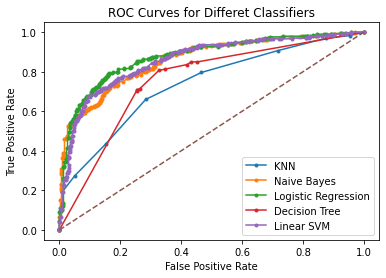

In [25]:
#Using models to make predictions and compare to the validation data set

resultsReal = []
ModelTypesReal = []
yscore =[]
print('')
print('Metrics when compared to validation data: \n')

for ModelType, model in models:
    model.fit(X,Y.ravel())
    result = model.predict(XVal)
    probs = model.predict_proba(XVal)
    probs = probs[:, 1]
    resultsReal.append(result)
    ModelTypesReal.append(ModelType)
    print (ModelType,"\naccuracy:", accuracy_score(YVal.ravel(),result))
    print("Confusion Matrix:","\n",confusion_matrix(YVal.ravel(),result),"\n")
    print("ROC area under curve:", roc_auc_score(YVal.ravel(),probs))
    print("Average Precision Score:",average_precision_score(YVal.ravel(),result),"\n\n")
    fpr, tpr, thresholds = roc_curve(YVal.ravel(), probs)
    plt.plot(fpr, tpr, marker='.')
    
plt.title("ROC Curves for Differet Classifiers")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["KNN","Naive Bayes","Logistic Regression","Decision Tree","Linear SVM"])
plt.plot([0, 1], [0, 1], linestyle='--')


# Feature Selection

## Defining Recursive feature elimination function

In [70]:
#choosing most representative words using recursive feature elimination (RFE)

from sklearn import datasets
from sklearn.feature_selection import RFE

def RFE_Function(num_features,models):

    for ModelName, model in models:
    
        rfe = RFE(model,num_features)
        rfe = rfe.fit(X,Y.ravel())

        bestVocab = []
        num = 0 

        #choosing the best words from the rfe analysis and putting them into a dictinoary
        for bool in rfe.support_:
            if bool  == True:
                bestVocab.append(vocab.iloc[num,0]) 
            num =num+1

        print("Top "+str(num_features)+" features for "+ ModelName +":\n\n", bestVocab, "\n")
    
        n=0
        
        #writing a text file with most representative words
        with open(ModelName + '_best_'+str(num_features)+'_vocab.txt', 'w') as f:
            for item in bestVocab:
                f.write("%s\n" % bestVocab[n])
                n = n + 1
        n=0


## Obtaining top "N" features features

In [71]:
#choosing best models
models_rfe = []
models_rfe.append(('NBC', MultinomialNB()))
models_rfe.append(('LogReg',LogisticRegression(solver='lbfgs',multi_class='ovr')))
models_rfe.append(('Tree', DecisionTreeClassifier()))

#how many top features do we want?
N=20

#running rfe
RFE_Function(N,models_rfe)

Top 20 features for NBC:

 ['hate', 'horribl', 'idea', 'junk', 'mediocr', 'mistak', 'pay', 'poor', 'poorli', 'ridicul', 'rude', 'sick', 'slow', 'start', 'stupid', 'suck', 'unit', 'unless', 'whatsoev', 'zero'] 

Top 20 features for LogReg:

 ['amaz', 'aw', 'awesom', 'bad', 'beauti', 'delici', 'excel', 'fantast', 'great', 'horribl', 'love', 'nice', 'perfect', 'poor', 'slow', 'suck', 'terribl', 'wast', 'wonder', 'worst'] 

Top 20 features for Tree:

 ['amaz', 'awesom', 'bad', 'beauti', 'best', 'delici', 'excel', 'fantast', 'fine', 'good', 'great', 'happi', 'highli', 'love', 'nice', 'poor', 'well', 'wonder', 'worst', 'would'] 



# How does training on only the top "N" features affect accuracy? 

In [74]:
#Running fit based on 20 best words with Naive Bayes Classifier (NBC)
#Here we load previously-created files made with the preprocesing script using only the top N features.
#Future work: shorten this with a simple function

model = MultinomialNB()
NBCFeatureAccuracy = []
NBCFeaturePrecision = []
NBCFeatureAUC=[]
FeatureNumber =[20,50,100,200,300,400,541]

bof20Best = pandas.read_csv("Words/20Best_bag_of_words_0.csv",header = None)
bof20BestTest = pandas.read_csv("Words/20BestTest_bag_of_words_0.csv",header = None)
X20Best = bof20Best.values
X20BestTest = bof20BestTest.values

model.fit(X20Best,Y.ravel())
Best20Result = model.predict(X20BestTest) 
print ("Best20", accuracy_score(Ytest.ravel(),Best20Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best20Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best20Result))
probs = model.predict_proba(X20BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 50 best words with Naive Bayes

bof50Best = pandas.read_csv("Words/50Best_bag_of_words_0.csv",header = None)
bof50BestTest = pandas.read_csv("Words/50BestTest_bag_of_words_0.csv",header = None)
X50Best = bof50Best.values
X50BestTest = bof50BestTest.values

model.fit(X50Best,Y.ravel())
Best50Result = model.predict(X50BestTest)
print ("Best50", accuracy_score(Ytest.ravel(),Best50Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best50Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best50Result))
probs = model.predict_proba(X50BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 100 best words with Naive Bayes

bof100Best = pandas.read_csv("Words/100Best_bag_of_words_0.csv",header = None)
bof100BestTest = pandas.read_csv("Words/100BestTest_bag_of_words_0.csv",header = None)
X100Best = bof100Best.values
X100BestTest = bof100BestTest.values

model.fit(X100Best,Y.ravel())
Best100Result = model.predict(X100BestTest)
print ("Best100", accuracy_score(Ytest.ravel(),Best100Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best100Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best100Result))
probs = model.predict_proba(X100BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 200 best words with Naive Bayes

bof200Best = pandas.read_csv("Words/200Best_bag_of_words_0.csv",header = None)
bof200BestTest = pandas.read_csv("Words/200BestTest_bag_of_words_0.csv",header = None)
X200Best = bof200Best.values
X200BestTest = bof200BestTest.values

model.fit(X200Best,Y.ravel())
Best200Result = model.predict(X200BestTest)
print ("Best200", accuracy_score(Ytest.ravel(),Best200Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best200Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best200Result))
probs = model.predict_proba(X200BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 300 best words with Naive Bayes

bof300Best = pandas.read_csv("Words/300Best_bag_of_words_0.csv",header = None)
bof300BestTest = pandas.read_csv("Words/300BestTest_bag_of_words_0.csv",header = None)
X300Best = bof300Best.values
X300BestTest = bof300BestTest.values

model.fit(X300Best,Y.ravel())
Best300Result = model.predict(X300BestTest)
print ("Best300", accuracy_score(Ytest.ravel(),Best300Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best300Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best300Result))
probs = model.predict_proba(X300BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 400 best words with Naive Bayes

bof400Best = pandas.read_csv("Words/400Best_bag_of_words_0.csv",header = None)
bof400BestTest = pandas.read_csv("Words/400BestTest_bag_of_words_0.csv",header = None)
X400Best = bof400Best.values
X400BestTest = bof400BestTest.values

model.fit(X400Best,Y.ravel())
Best400Result = model.predict(X400BestTest)
print ("Best400", accuracy_score(Ytest.ravel(),Best400Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best400Result))
NBCFeatureAccuracy.append(0.77) #for full vocabulary
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best400Result))
NBCFeaturePrecision.append(0.71) #for full vocabulary
probs = model.predict_proba(X400BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))
NBCFeatureAUC.append(0.86) #for full vocabulary

Best20 0.48833333333333334
Best50 0.4633333333333333
Best100 0.475
Best200 0.505
Best300 0.5483333333333333
Best400 0.61


In [75]:
#Running fit based on 20 best words with log regression
LogRegFeatureAccuracy = []
LogRegFeaturePrecision = []
LogRegFeatureAUC = []

model = LogisticRegression(solver='lbfgs',multi_class='ovr')

bof20Best = pandas.read_csv("Words/20BestLogReg_bag_of_words_0.csv",header = None)
bof20BestTest = pandas.read_csv("Words/20BestLogRegTest_bag_of_words_0.csv",header = None)
X20Best = bof20Best.values
X20BestTest = bof20BestTest.values

model.fit(X20Best,Y.ravel())
Best20Result = model.predict(X20BestTest) 
print ("Best20LogReg", accuracy_score(Ytest.ravel(),Best20Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best20Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best20Result))
probs = model.predict_proba(X20BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 50 best words with log regression

bof50Best = pandas.read_csv("Words/50BestLogReg_bag_of_words_0.csv",header = None)
bof50BestTest = pandas.read_csv("Words/50BestLogRegTest_bag_of_words_0.csv",header = None)
X50Best = bof50Best.values
X50BestTest = bof50BestTest.values

model.fit(X50Best,Y.ravel())
Best50Result = model.predict(X50BestTest)
print ("Best50LogReg", accuracy_score(Ytest.ravel(),Best50Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best50Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best50Result))
probs = model.predict_proba(X50BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 100 best words with log regression

bof100Best = pandas.read_csv("Words/100BestLogReg_bag_of_words_0.csv",header = None)
bof100BestTest = pandas.read_csv("Words/100BestLogRegTest_bag_of_words_0.csv",header = None)
X100Best = bof100Best.values
X100BestTest = bof100BestTest.values

model.fit(X100Best,Y.ravel())
Best100Result = model.predict(X100BestTest)
print ("Best100LogReg", accuracy_score(Ytest.ravel(),Best100Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best100Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best100Result))
probs = model.predict_proba(X100BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 200 best words with log regression

bof200Best = pandas.read_csv("Words/200BestLogReg_bag_of_words_0.csv",header = None)
bof200BestTest = pandas.read_csv("Words/200BestLogRegTest_bag_of_words_0.csv",header = None)
X200Best = bof200Best.values
X200BestTest = bof200BestTest.values

model.fit(X200Best,Y.ravel())
Best200Result = model.predict(X200BestTest)
print ("Best200LogReg", accuracy_score(Ytest.ravel(),Best200Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best200Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best200Result))
probs = model.predict_proba(X200BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 300 best words with log regression

bof300Best = pandas.read_csv("Words/300BestLogReg_bag_of_words_0.csv",header = None)
bof300BestTest = pandas.read_csv("Words/300BestLogRegTest_bag_of_words_0.csv",header = None)
X300Best = bof300Best.values
X300BestTest = bof300BestTest.values

model.fit(X300Best,Y.ravel())
Best300Result = model.predict(X300BestTest)
print ("Best300LogReg", accuracy_score(Ytest.ravel(),Best300Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best300Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best300Result))
probs = model.predict_proba(X300BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 400 best words

bof400Best = pandas.read_csv("Words/400BestLogReg_bag_of_words_0.csv",header = None)
bof400BestTest = pandas.read_csv("Words/400BestLogRegTest_bag_of_words_0.csv",header = None)
X400Best = bof400Best.values
X400BestTest = bof400BestTest.values

model.fit(X400Best,Y.ravel())
Best400Result = model.predict(X400BestTest)
print ("Best400LogReg", accuracy_score(Ytest.ravel(),Best400Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best400Result))
LogRegFeatureAccuracy.append(0.802) #for full vocabulary
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best400Result))
LogRegFeaturePrecision.append(0.75) #for full vocabulary
probs = model.predict_proba(X400BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))
LogRegFeatureAUC.append(0.88) #for full vocabulary


Best20LogReg 0.6616666666666666
Best50LogReg 0.75
Best100LogReg 0.78
Best200LogReg 0.8166666666666667
Best300LogReg 0.8183333333333334
Best400LogReg 0.8083333333333333


In [76]:
#Running fit based on 20 best words with decision tree
model =DecisionTreeClassifier()
TreeFeatureAccuracy = []
TreeFeaturePrecision = []
TreeFeatureAUC = []


bof20Best = pandas.read_csv("Words/20BestTree_bag_of_words_0.csv",header = None)
bof20BestTest = pandas.read_csv("Words/20BestTreeTest_bag_of_words_0.csv",header = None)
X20Best = bof20Best.values
X20BestTest = bof20BestTest.values

model.fit(X20Best,Y.ravel())
Best20Result = model.predict(X20BestTest) 
print ("Best20Tree", accuracy_score(Ytest.ravel(),Best20Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best20Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best20Result))
probs = model.predict_proba(X20BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 50 best words with log regression

bof50Best = pandas.read_csv("Words/50BestTree_bag_of_words_0.csv",header = None)
bof50BestTest = pandas.read_csv("Words/50BestTreeTest_bag_of_words_0.csv",header = None)
X50Best = bof50Best.values
X50BestTest = bof50BestTest.values

model.fit(X50Best,Y.ravel())
Best50Result = model.predict(X50BestTest)
print ("Best50Tree", accuracy_score(Ytest.ravel(),Best50Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best50Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best50Result))
probs = model.predict_proba(X50BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 100 best words with log regression

bof100Best = pandas.read_csv("Words/100BestTree_bag_of_words_0.csv",header = None)
bof100BestTest = pandas.read_csv("Words/100BestTreeTest_bag_of_words_0.csv",header = None)
X100Best = bof100Best.values
X100BestTest = bof100BestTest.values

model.fit(X100Best,Y.ravel())
Best100Result = model.predict(X100BestTest)
print ("Best100Test", accuracy_score(Ytest.ravel(),Best100Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best100Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best100Result))
probs = model.predict_proba(X100BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 200 best words with log regression

bof200Best = pandas.read_csv("Words/200BestTree_bag_of_words_0.csv",header = None)
bof200BestTest = pandas.read_csv("Words/200BestTreeTest_bag_of_words_0.csv",header = None)
X200Best = bof200Best.values
X200BestTest = bof200BestTest.values

model.fit(X200Best,Y.ravel())
Best200Result = model.predict(X200BestTest)
print ("Best200Tree", accuracy_score(Ytest.ravel(),Best200Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best200Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best200Result))
probs = model.predict_proba(X200BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 300 best words with log regression

bof300Best = pandas.read_csv("Words/300BestTree_bag_of_words_0.csv",header = None)
bof300BestTest = pandas.read_csv("Words/300BestTreeTest_bag_of_words_0.csv",header = None)
X300Best = bof300Best.values
X300BestTest = bof300BestTest.values

model.fit(X300Best,Y.ravel())
Best300Result = model.predict(X300BestTest)
print ("Best300Tree", accuracy_score(Ytest.ravel(),Best300Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best300Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best300Result))
probs = model.predict_proba(X300BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 400 best words

bof400Best = pandas.read_csv("Words/400BestTree_bag_of_words_0.csv",header = None)
bof400BestTest = pandas.read_csv("Words/400BestTreeTest_bag_of_words_0.csv",header = None)
X400Best = bof400Best.values
X400BestTest = bof400BestTest.values

model.fit(X400Best,Y.ravel())
Best400Result = model.predict(X400BestTest)
print ("Best400Tree", accuracy_score(Ytest.ravel(),Best400Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best400Result))
TreeFeatureAccuracy.append(0.74) #for full vocabulary
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best400Result))
TreeFeaturePrecision.append(0.67)
probs = model.predict_proba(X400BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))
TreeFeatureAUC.append(0.76)

Best20Tree 0.7066666666666667
Best50Tree 0.7566666666666667
Best100Test 0.7716666666666666
Best200Tree 0.77
Best300Tree 0.75
Best400Tree 0.73


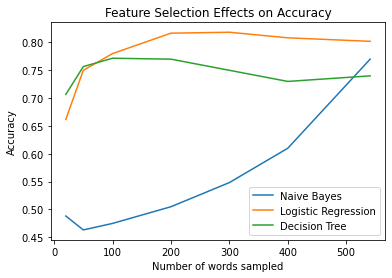

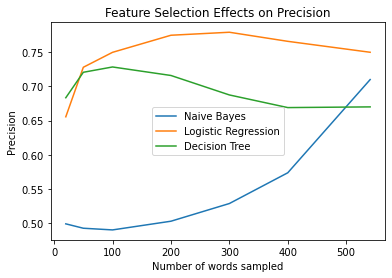

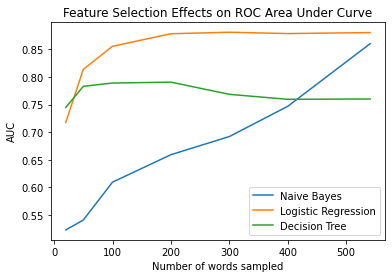

In [77]:
#plotting feature selection effects on accuracy

plt.plot(FeatureNumber,NBCFeatureAccuracy,FeatureNumber,LogRegFeatureAccuracy,FeatureNumber,TreeFeatureAccuracy,)
plt.title("Feature Selection Effects on Accuracy")
plt.xlabel("Number of words sampled")
plt.ylabel("Accuracy")
plt.legend(["Naive Bayes","Logistic Regression","Decision Tree"])

#plotting feature selection effects on precision
plt.figure()
plt.plot(FeatureNumber,NBCFeaturePrecision,FeatureNumber,LogRegFeaturePrecision,FeatureNumber,TreeFeaturePrecision,)
plt.title("Feature Selection Effects on Precision")
plt.xlabel("Number of words sampled")
plt.ylabel("Precision")
plt.legend(["Naive Bayes","Logistic Regression","Decision Tree"])

#plotting feature selection effects on AUC
plt.figure()
plt.plot(FeatureNumber,NBCFeatureAUC,FeatureNumber,LogRegFeatureAUC,FeatureNumber,TreeFeatureAUC)
plt.title("Feature Selection Effects on ROC Area Under Curve")
plt.xlabel("Number of words sampled")
plt.ylabel("AUC")
plt.legend(["Naive Bayes","Logistic Regression","Decision Tree"])

# Adding review length as an additional feature to the analysis

## Functions to obtain review length from raw data

In [65]:
#splitting each review into its words
def readLines(file):
    with open(file, 'r') as f:
        for line in f:
            yield line.strip()

#counting words in each line
def wordsInScentence(sentences):
    counts = []
    for sentence in sentences:
        #cunts.append(sentence.split()) #minus two because we have label and number
        counts.append(len(sentence.split())-2)#two because we have label and number
    return counts

#reading number of words in each data set (tranining and testing)
X2Train = wordsInScentence(readLines("Words/train.txt"))
X2Train = np.reshape(X2Train,(-1, 1))

X2Test = wordsInScentence(readLines("Words/test.txt"))
X2Test = np.reshape(X2Test,(-1, 1))

## Comparing prediction power with length as a feature

In [67]:
#setting up and choosing the models to compare
models2 = []
models2.append(('KNN', KNeighborsClassifier(10)))
models2.append(('NBC', MultinomialNB()))
models2.append(('LogReg',LogisticRegression(solver='lbfgs',multi_class='ovr')))
models2.append(('Tree', DecisionTreeClassifier()))

resultsReal2 = []
ModelTypesReal2=[]

print('')
print('Accuracy when using scentence length as the only feature')

for ModelType, model in models2:
    model.fit(X2Train,Y.ravel())
    result = model.predict(X2Test) 
    resultsReal2.append(result)
    ModelTypesReal2.append(ModelType)
    print (ModelType, accuracy_score(Ytest.ravel(),result))

#fitting model using word AND length data
X2LengthTrain = np.concatenate((X,X2Train),axis = 1)
X2LengthTest = np.concatenate((Xtest,X2Test),axis = 1)

print('')
print('Accuracy when using scentence length and Bag of Words')

for ModelType, model in models2:
    model.fit(X2LengthTrain,Y.ravel())
    result = model.predict(X2LengthTest) 
    resultsReal2.append(result)
    ModelTypesReal2.append(ModelType)
    print (ModelType, accuracy_score(Ytest.ravel(),result))



Accuracy when using scentence length as the only feature
KNN 0.5183333333333333
NBC 0.5
LogReg 0.49
Tree 0.535

Accuracy when using scentence length and Bag of Words
KNN 0.5366666666666666
NBC 0.7733333333333333
LogReg 0.7966666666666666
Tree 0.7016666666666667


Review length is NOT correlated with the sentiment of a review